In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=e13a36ee0ed84b38cca3cd38b56ad20b4504e1e932c8ebb64450db93ef64829e
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%pylab inline
import plotly.express as px
import time

import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
                                      NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import regexp_replace, col

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#evaluation and feature engineering
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour,NearMiss,EditedNearestNeighbours, RandomUnderSampler
from datetime import datetime, date
from imblearn.combine import SMOTEENN, SMOTETomek
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,\
                                       NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import regexp_replace, col
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
!kaggle datasets download -d dhoogla/unswnb15

!mkdir -p "/content/drive/My Drive/dhoogla/unswnb15/"
!cp unswnb15.zip "/content/drive/My Drive/dhoogla/unswnb15"
!unzip "/content/drive/My Drive/dhoogla/unswnb15/unswnb15.zip"

unswnb15.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/My Drive/dhoogla/unswnb15/unswnb15.zip
replace UNSW_NB15_testing-set.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Read the UNSW_NB15 Dataset
df = pd.read_parquet('UNSW_NB15_training-set.parquet')
df

# Check the first 5 rows
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,Normal,0


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                82332 non-null  float32 
 1   proto              82332 non-null  category
 2   service            82332 non-null  category
 3   state              82332 non-null  category
 4   spkts              82332 non-null  int16   
 5   dpkts              82332 non-null  int16   
 6   sbytes             82332 non-null  int32   
 7   dbytes             82332 non-null  int32   
 8   rate               82332 non-null  float32 
 9   sload              82332 non-null  float32 
 10  dload              82332 non-null  float32 
 11  sloss              82332 non-null  int16   
 12  dloss              82332 non-null  int16   
 13  sinpkt             82332 non-null  float32 
 14  dinpkt             82332 non-null  float32 
 15  sjit               82332 non-null  float32 
 16  djit

In [ ]:
df.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,82332.000000,8.233200e+04,8.233200e+04,82332.000000,82332.000000,...,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,82410.890625,6.454902e+07,6.305469e+05,4.753692,6.308556,...,116.275069,0.094277,1.595372e+03,4.928898,3.663011,0.008284,0.008381,0.129743,0.011126,0.550600
std,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,148620.375000,1.798618e+08,2.393000e+06,64.649620,55.708021,...,244.600271,0.542922,3.806697e+04,8.389545,5.915386,0.091171,0.092485,0.638683,0.104891,0.497436
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,28.606114,1.120247e+04,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2650.176758,5.770032e+05,2.112951e+03,1.000000,0.000000,...,44.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,111111.109375,6.514286e+07,1.585808e+04,3.000000,2.000000,...,87.000000,0.000000,0.000000e+00,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1000000.000000,5.268000e+09,2.082111e+07,5319.000000,5507.000000,...,1500.000000,131.000000,5.242880e+06,59.000000,38.000000,2.000000,2.000000,16.000000,1.000000,1.000000


In [ ]:
# Check for missing values in the DataFrame
missing_values = df.isna().sum()
print("Missing values before treatment:")
print(missing_values)

Missing values before treatment:
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
is_sm_ips_ports      0
attack_cat           0
label                0
dtype: int64


In [ ]:
positive_inf_count = (df == np.inf).sum().sum()
print(f"Total positive infinity values in the DataFrame: {positive_inf_count}")
negative_inf_count = (df == -np.inf).sum().sum()
print(f"Total negative infinity values in the DataFrame: {negative_inf_count}")

Total positive infinity values in the DataFrame: 0
Total negative infinity values in the DataFrame: 0


In [ ]:

df.replace([np.inf, -np.inf], np.nan, inplace =True)
df.dropna(inplace = True)
cols= df.columns

In [ ]:
df = df.rename(columns={"label": "target"})
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                82332 non-null  float32 
 1   proto              82332 non-null  category
 2   service            82332 non-null  category
 3   state              82332 non-null  category
 4   spkts              82332 non-null  int16   
 5   dpkts              82332 non-null  int16   
 6   sbytes             82332 non-null  int32   
 7   dbytes             82332 non-null  int32   
 8   rate               82332 non-null  float32 
 9   sload              82332 non-null  float32 
 10  dload              82332 non-null  float32 
 11  sloss              82332 non-null  int16   
 12  dloss              82332 non-null  int16   
 13  sinpkt             82332 non-null  float32 
 14  dinpkt             82332 non-null  float32 
 15  sjit               82332 non-null  float32 
 16  djit

In [ ]:
label_encoder =LabelEncoder()
df['proto'] = label_encoder.fit_transform(df['proto'])

df['service'] = label_encoder.fit_transform(df['service'])
df['state'] = label_encoder.fit_transform(df['state'])
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,target
0,0.000011,117,0,4,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,6,0
1,0.000008,117,0,4,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,6,0
2,0.000005,117,0,4,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,6,0
3,0.000006,117,0,4,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,6,0
4,0.000010,117,0,4,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,6,0


In [ ]:
X= df.drop(columns = 'target')
y= df['target']


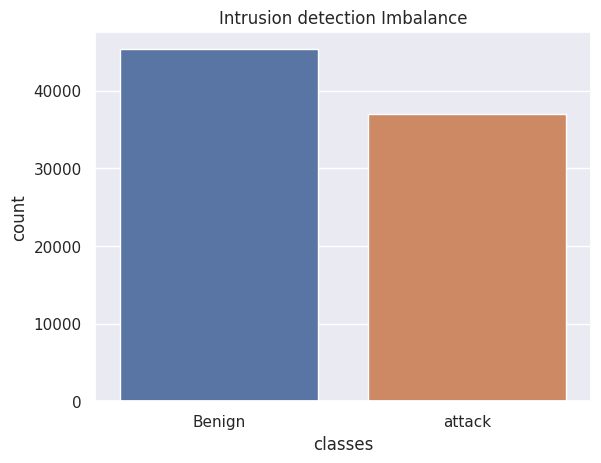

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
label_class= df['target'].value_counts()
sns.barplot(x=['Benign','attack',],y=label_class)
plt.title("Intrusion detection Imbalance")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
# smt = SMOTE()
# X_resampled, y_resampled = smt.fit_resample(X, y)

from imblearn.under_sampling import TomekLinks

# Balancing the dataset using Tomek Links
tl = TomekLinks(
     sampling_strategy='auto',
     n_jobs=4)

X_resampled, y_resampled = tl.fit_resample(X, y)

# nm2 = NearMiss(
#     sampling_strategy='auto',
#     version=2)
# X_resampled, y_resampled = nm2.fit_resample(X, y)

# rus = RandomUnderSampler(sampling_strategy='auto', s
#     random_state=0,
#     replacement=True )
# X_resampled, y_resampled = rus.fit_resample(X, y)

# ros = RandomOverSampler()
# X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
X_resampled['target'] = y_resampled

In [ ]:
spark = SparkSession.builder.appName("Network Attacks Classifier").master("local").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

start = time.time()

In [ ]:
X_resampled.to_csv("file1.csv")

In [ ]:
df = spark.read.csv('file1.csv', header = True, inferSchema = True)
df.printSchema()
cols=df.columns

root
 |-- _c0: integer (nullable = true)
 |-- dur: double (nullable = true)
 |-- proto: integer (nullable = true)
 |-- service: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- spkts: integer (nullable = true)
 |-- dpkts: integer (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- rate: double (nullable = true)
 |-- sload: double (nullable = true)
 |-- dload: double (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- sinpkt: double (nullable = true)
 |-- dinpkt: double (nullable = true)
 |-- sjit: double (nullable = true)
 |-- djit: double (nullable = true)
 |-- swin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- tcprtt: double (nullable = true)
 |-- synack: double (nullable = true)
 |-- ackdat: double (nullable = true)
 |-- smean: integer (nullable = true)
 |-- dmean: integer (nul

In [ ]:
df = df.drop('attack_cat')
df.show()

+---+------+-----+-------+-----+-----+-----+------+------+---------+-----------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------------+----------------+------------+----------+----------------+---------------+------+
|_c0|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|     rate|      sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_src_dport_ltm|ct_dst_sport_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|is_sm_ips_ports|target|
+---+------+-----+-------+-----+-----+-----+------+------+---------+-----------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------------+----------------+------------+----------+----------------+---------------+------+
|  0|1.1E-5|  117|      0|    4|    2|    0|   496|     0| 90909.09|1.803

In [ ]:
features = [f for f in df.columns if f not in ["target"]]
#result , loop, condition
df_assembler = VectorAssembler(inputCols=features, outputCol="features").setHandleInvalid("skip")
dataset = df_assembler.transform(df)
dataset.printSchema()

label_indexer = StringIndexer(inputCol="target", outputCol="label").setHandleInvalid("skip").fit(dataset)
dataset = label_indexer.transform(dataset)
dataset.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- dur: double (nullable = true)
 |-- proto: integer (nullable = true)
 |-- service: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- spkts: integer (nullable = true)
 |-- dpkts: integer (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- rate: double (nullable = true)
 |-- sload: double (nullable = true)
 |-- dload: double (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- sinpkt: double (nullable = true)
 |-- dinpkt: double (nullable = true)
 |-- sjit: double (nullable = true)
 |-- djit: double (nullable = true)
 |-- swin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- tcprtt: double (nullable = true)
 |-- synack: double (nullable = true)
 |-- ackdat: double (nullable = true)
 |-- smean: integer (nullable = true)
 |-- dmean: integer (nul

In [ ]:
# dataset.select(["Label", "Label_Idx"]).distinct().orderBy("Label_Idx").show()
label_list = dataset.select(["label"]).distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()

print(label_list)

dataset = dataset.select(["features", "label"])
dataset.printSchema()

# Splitting the dataset into training and testing sets
train_set, test_set = dataset.randomSplit([0.75, 0.25], seed=42)
print("Training set Count: " + str(train_set.count()))
print("Test set Count: " + str(test_set.count()))



[0.0, 1.0]
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)

Training set Count: 58532
Test set Count: 19675


In [ ]:
# Logistic Regression model
lr = LogisticRegression()

# Decision Tree model
dt = DecisionTreeClassifier()

# Random Forest model
rf = RandomForestClassifier()

# Naive Bayes Multinomial
nb = NaiveBayes()

classifiers = {"Logistic Regression": lr, "Decision Tree": dt,
                "Random Forest": rf, "Naive Bayes Multinomial": nb}

metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

print("\nModels Evaluation:")
print("{:-<24}".format(""))



Models Evaluation:
------------------------


In [ ]:
lr.fit(train_set)
train_set.show()


+--------------------+-----+
|            features|label|
+--------------------+-----+
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  1.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
|(35,[0,1,2,3,4,5,...|  0.0|
+--------------------+-----+
only showing top 20 rows



Logistic Regression
accuracy = 0.88
weightedPrecision = 0.88
weightedRecall = 0.88
f1 = 0.88
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89     10322
         1.0       0.86      0.90      0.88      9353

    accuracy                           0.88     19675
   macro avg       0.88      0.88      0.88     19675
weighted avg       0.88      0.88      0.88     19675

Decision Tree
accuracy = 0.99
weightedPrecision = 0.99
weightedRecall = 0.99
f1 = 0.99
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     10322
         1.0       0.99      0.99      0.99      9353

    accuracy                           0.99     19675
   macro avg       0.99      0.99      0.99     19675
weighted avg       0.99      0.99      0.99     19675

Random Forest
accuracy = 0.97
weightedPrecision = 0.97
weightedRecall = 0.97
f1 = 0.97
              precision    recall  f1-score   support

         0.0       0.95 

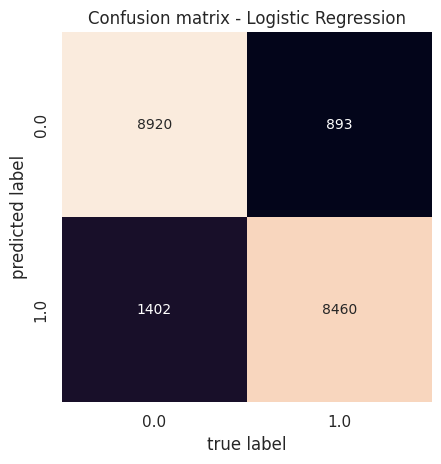

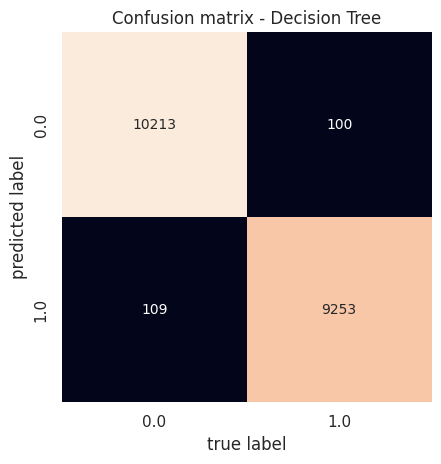

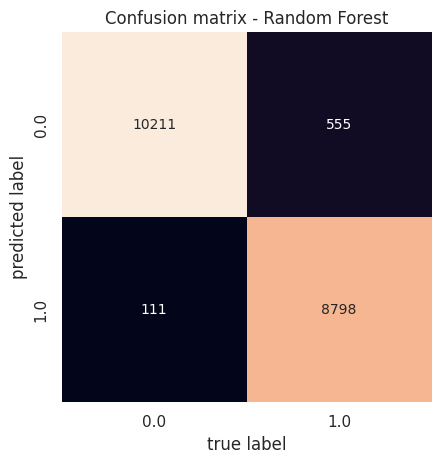

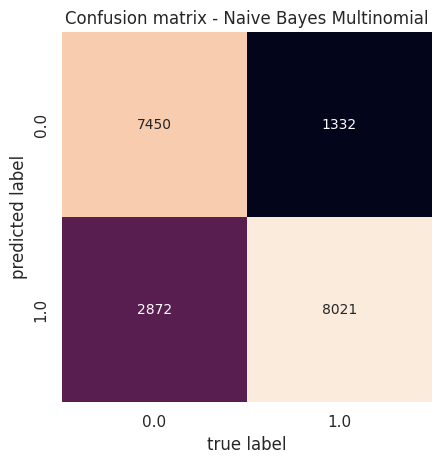

In [ ]:
for idx, c in enumerate(classifiers):
    print(c)
    # fit the model
    model = classifiers[c].fit(train_set)

    # make predictions
    predictions = model.transform(test_set)
    predictions.cache()

    # evaluate performance
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

    for m in metrics:
        evaluator.setMetricName(m)
        metric = evaluator.evaluate(predictions)
        print("{name} = {value:.2f}".format(name=m, value=metric))

    # Build confusion matrix using Scikit-learn (sktlearn)
    target_list = predictions.select("label").rdd.flatMap(lambda x: x).collect()
    pred_list = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    label_num_list = predictions.select("label").distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()
    # print("\nClassification report using Sklearn:")
    print(classification_report(target_list, pred_list))
    conf_matrix = confusion_matrix(target_list, pred_list)
    plt.figure(idx)
    plt.title("Confusion matrix - {model}".format(model=c))
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
                annot_kws={"size": 10}, xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()
plt.show()


